# How Random Forest Hyperparameters Shape Decision Boundaries
### Breast Cancer Wisconsin (Diagnostic) — Full tutorial notebook

This notebook contains a complete pipeline you can run in Google Colab or Jupyter:
- Load the **Breast Cancer** dataset (built-in sklearn version)
- EDA (brief)
- Random Forest feature importance and selecting top features
- Decision boundaries using top-2 raw features
- PCA (2 components) and decision boundary
- NCA (2 components) and decision boundary
- Compare methods and select the best
- Study individual hyperparameters (max_depth, n_estimators, max_features)
- GridSearchCV tuning and interpretation plots

Each code cell includes student-friendly comments and short textual explanation for key points and keywords.



In [1]:
# Importing all the libraries needed for this tutorial.
# These include tools for data handling (NumPy/Pandas), plotting (Matplotlib),
# and machine learning methods from scikit-learn such as Random Forests,
# feature reduction (PCA and NCA), and evaluation metrics.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.inspection import permutation_importance

%matplotlib inline
print('Libraries loaded.')


Libraries loaded.


## 1. Load data and quick overview

**Keywords:** dataset, features, target, shape

used `sklearn.datasets.load_breast_cancer` for a clean copy of the Breast Cancer dataset.


In [2]:
# Load the Breast Cancer dataset and separate features and labels
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names
target_names = data.target_names

# View basic dataset information
print('Feature count:', X.shape[1])
print('Sample count:', X.shape[0])
print('Target names:', target_names)

# Convert to a DataFrame for easier inspection
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y
df.head()


Feature count: 30
Sample count: 569
Target names: ['malignant' 'benign']


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [3]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


## 2. Brief EDA (exploratory data analysis)

Show distributions of a few top features and a correlation heatmap. **Keep EDA compact** for the report.


<Figure size 640x480 with 0 Axes>

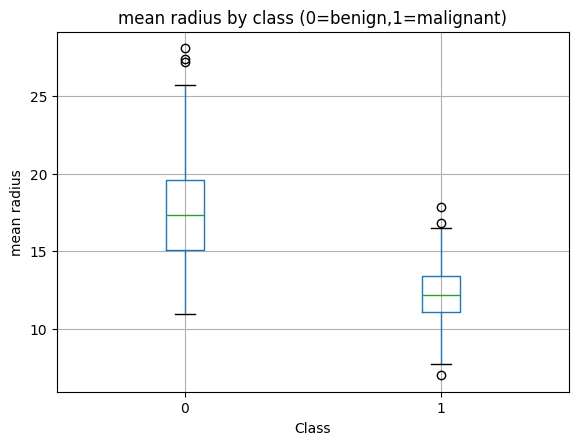

<Figure size 640x480 with 0 Axes>

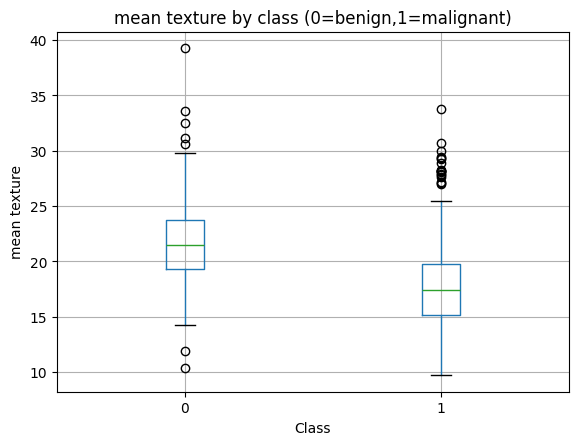

<Figure size 640x480 with 0 Axes>

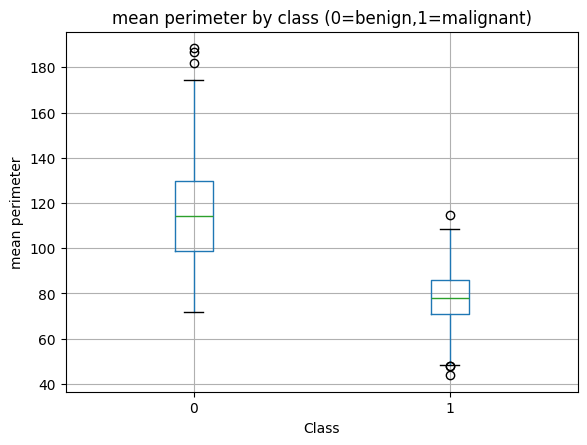

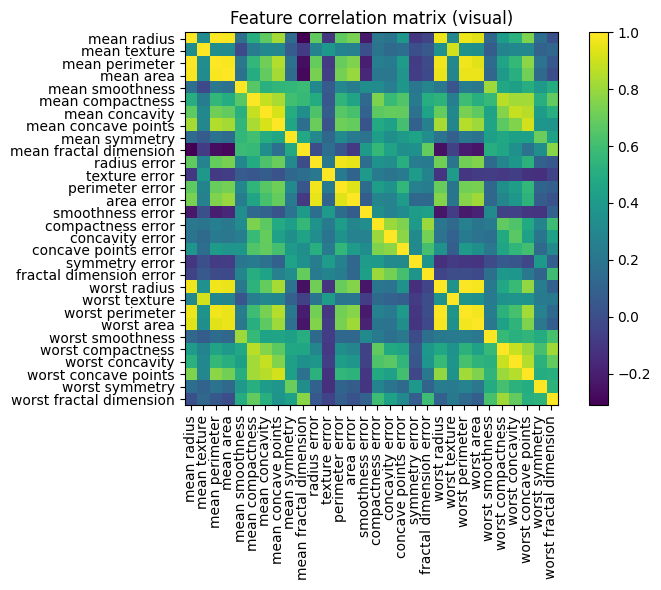

In [4]:
# Boxplots for a few selected features to see how they differ between classes
sample_features = ['mean radius', 'mean texture', 'mean perimeter']
for feat in sample_features:
    plt.figure()
    df.boxplot(column=feat, by='target')
    plt.title(f'{feat} by class (0=benign,1=malignant)')
    plt.suptitle('')   # remove automatic title
    plt.xlabel('Class')
    plt.ylabel(feat)
    plt.show()

# Compute and display a simple correlation heatmap for all features
corr = df.drop(columns=['target']).corr()
plt.figure(figsize=(8,6))
plt.imshow(corr, interpolation='nearest')
plt.title('Feature correlation matrix (visual)')
plt.colorbar()
plt.xticks(range(len(feature_names)), feature_names, rotation=90)
plt.yticks(range(len(feature_names)), feature_names)
plt.tight_layout()
plt.show()


## 3. Random Forest Feature Importance (Gini) and Permutation Importance

**Keywords:** feature importance, Gini importance, permutation importance, interpretability

We train a Random Forest on the full feature set and extract feature importances. Then compute permutation importance for more robust ranking.


Top 10 features by Gini importance:
worst perimeter: 0.1409
worst area: 0.1318
worst concave points: 0.1223
worst radius: 0.0849
mean concave points: 0.0771
mean radius: 0.0669
mean perimeter: 0.0577
mean area: 0.0461
mean concavity: 0.0447
worst concavity: 0.0349


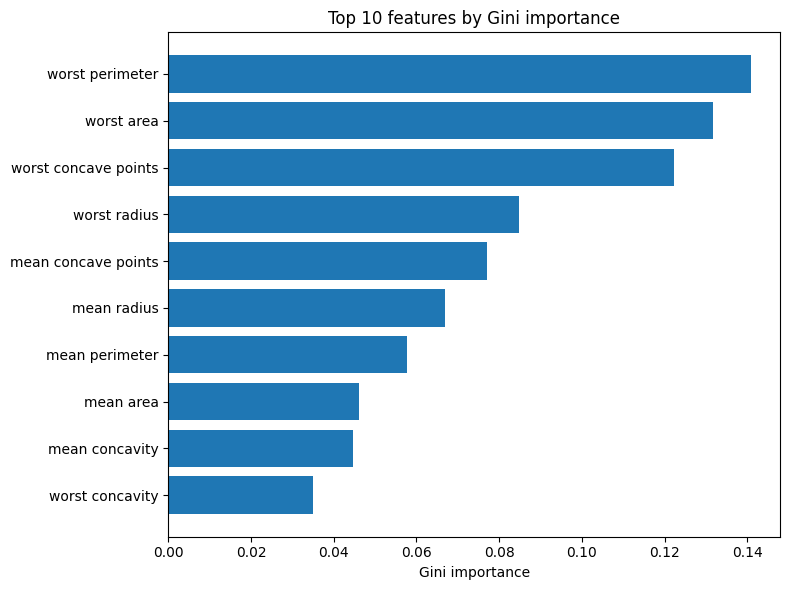


Top 10 features by permutation importance:
worst texture: mean imp=0.0094, std=0.0034
mean texture: mean imp=0.0053, std=0.0037
perimeter error: mean imp=0.0050, std=0.0050
symmetry error: mean imp=0.0047, std=0.0023
concavity error: mean imp=0.0044, std=0.0025
mean concavity: mean imp=0.0038, std=0.0033
worst symmetry: mean imp=0.0035, std=0.0029
mean concave points: mean imp=0.0035, std=0.0034
area error: mean imp=0.0029, std=0.0029
radius error: mean imp=0.0029, std=0.0029


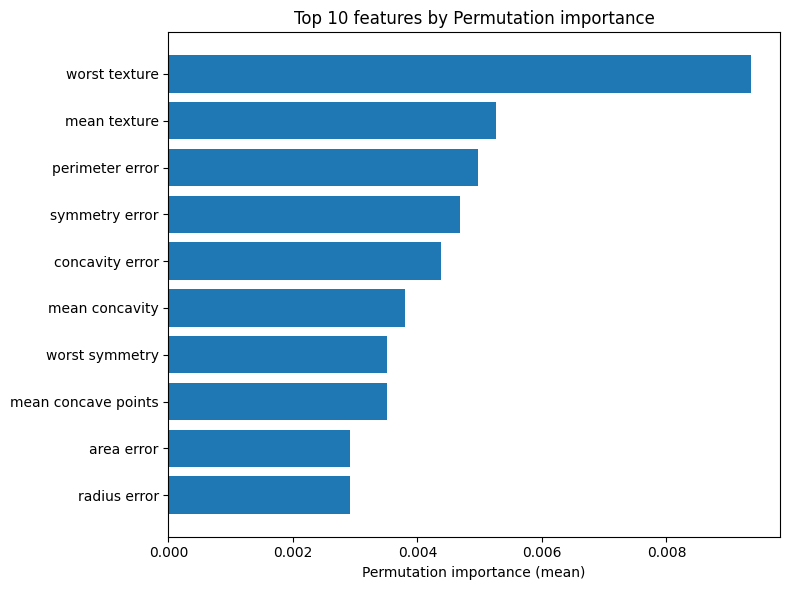

In [5]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Train a Random Forest model on all features to check overall importance
rf_full = RandomForestClassifier(n_estimators=200, random_state=42)
rf_full.fit(X_train, y_train)

# Extract Gini feature importances and display the top 10
gini_importances = rf_full.feature_importances_
gini_idx = np.argsort(gini_importances)[::-1]
print('Top 10 features by Gini importance:')
for i in gini_idx[:10]:
    print(f"{feature_names[i]}: {gini_importances[i]:.4f}")

# Plot the top 10 Gini importances
plt.figure(figsize=(8,6))
plt.barh(range(10), gini_importances[gini_idx[:10]][::-1])
plt.yticks(range(10), [feature_names[i] for i in gini_idx[:10]][::-1])
plt.xlabel('Gini importance')
plt.title('Top 10 features by Gini importance')
plt.tight_layout()
plt.show()

# Compute permutation importance for a more robust ranking
perm = permutation_importance(rf_full, X_test, y_test,
                              n_repeats=20, random_state=42, n_jobs=-1)
perm_idx = np.argsort(perm.importances_mean)[::-1]

print('\nTop 10 features by permutation importance:')
for i in perm_idx[:10]:
    print(f"{feature_names[i]}: mean imp={perm.importances_mean[i]:.4f}, "
          f"std={perm.importances_std[i]:.4f}")

# Plot the top 10 permutation importances
plt.figure(figsize=(8,6))
plt.barh(range(10), perm.importances_mean[perm_idx[:10]][::-1])
plt.yticks(range(10), [feature_names[i] for i in perm_idx[:10]][::-1])
plt.xlabel('Permutation importance (mean)')
plt.title('Top 10 features by Permutation importance')
plt.tight_layout()
plt.show()


## 4. Pick top 2 original features (from permutation importance) and plot decision boundary

We use the top two features from permutation importance because they better reflect model performance.


Top 2 features chosen for 2D plots: [np.str_('worst texture'), np.str_('mean texture')]
Accuracy on test (top2 raw features): 0.7076023391812866


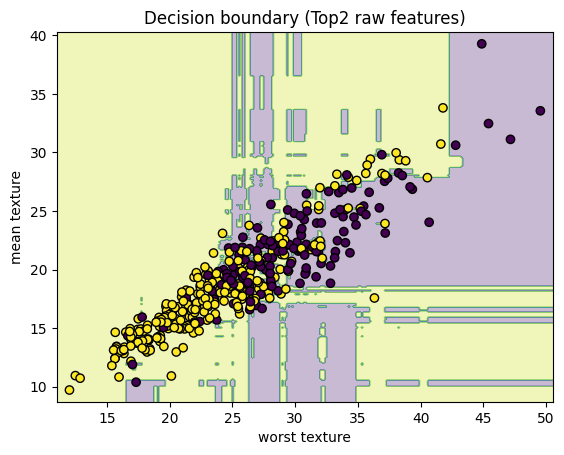

In [6]:
# Pick the two most important features based on permutation importance
top2 = perm_idx[:2]
top2_names = [feature_names[i] for i in top2]
print('Top 2 features chosen for 2D plots:', top2_names)

# Create a smaller dataset using only these two features
X2 = X[:, top2]
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y, test_size=0.3, random_state=42, stratify=y
)

def plot_decision_boundary(model, X_plot, y_plot, title='Decision boundary'):
    # Make a grid over the feature space so we can see how the model separates classes
    x_min, x_max = X_plot[:, 0].min() - 1, X_plot[:, 0].max() + 1
    y_min, y_max = X_plot[:, 1].min() - 1, X_plot[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))

    # Predict class for every point in the grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision regions and the actual data points
    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, edgecolor='k')
    plt.xlabel(top2_names[0])
    plt.ylabel(top2_names[1])
    plt.title(title)
    plt.show()

# Train a Random Forest using only the top two features
rf_top2 = RandomForestClassifier(n_estimators=200, random_state=42)
rf_top2.fit(X2_train, y2_train)

# Print accuracy and show the decision boundary
print('Accuracy on test (top2 raw features):',
      accuracy_score(y2_test, rf_top2.predict(X2_test)))

plot_decision_boundary(rf_top2, X2_train, y2_train,
                       title='Decision boundary (Top2 raw features)')


## 5. PCA (2 components) — transform, train RF, plot boundary

PCA is an unsupervised method that finds directions of greatest variance in the data.
We standardise features first, then reduce to two principal components to compare how well this 2D view separates the classes.


Accuracy on test (PCA 2 components): 0.9415204678362573


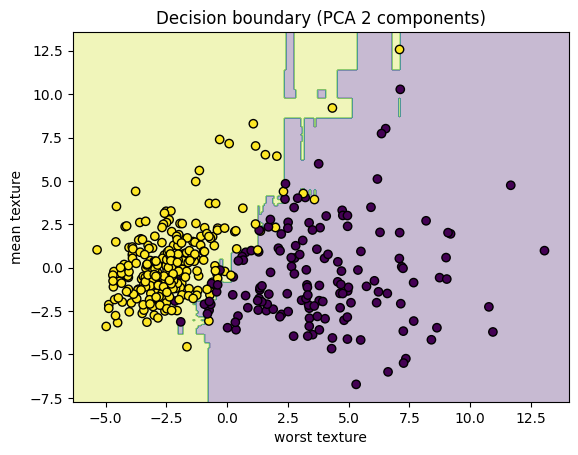

In [7]:
# Scale the data before applying PCA since PCA works best on standardised features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce the dataset to 2 principal components
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Split the PCA-transformed data
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(
    X_pca, y, test_size=0.3, random_state=42, stratify=y
)

# Train a Random Forest on the PCA-reduced features
rf_pca = RandomForestClassifier(n_estimators=200, random_state=42)
rf_pca.fit(X_pca_train, y_pca_train)

# Check performance on the test set
print('Accuracy on test (PCA 2 components):',
      accuracy_score(y_pca_test, rf_pca.predict(X_pca_test)))

# Visualise the decision boundary in the 2D PCA feature space
plot_decision_boundary(rf_pca, X_pca_train, y_pca_train,
                       title='Decision boundary (PCA 2 components)')


## 6. NCA (2 components) — supervised projection, train RF, plot boundary

NCA (Neighborhood Components Analysis) learns a projection that optimises nearest-neighbour classification. It is supervised and often produces better class separation than PCA for classification tasks.


Accuracy on test (NCA 2 components): 0.9941520467836257


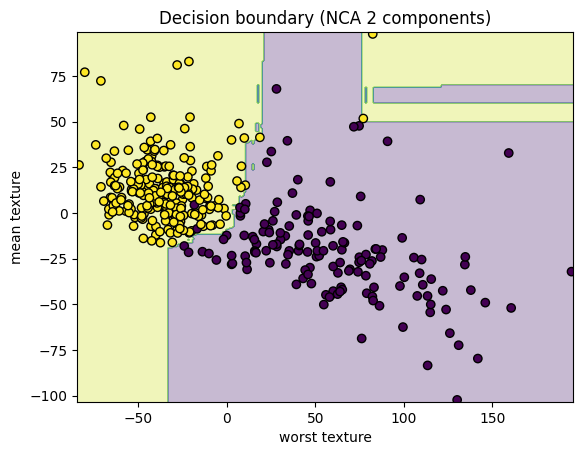

In [8]:
# Scale the data before using NCA (works best with standardised features)
scaler2 = StandardScaler()
X_scaled2 = scaler2.fit_transform(X)

# Apply NCA to learn a 2D representation that helps separate the classes
nca = NeighborhoodComponentsAnalysis(n_components=2, random_state=42)
X_nca = nca.fit_transform(X_scaled2, y)

# Train–test split for the NCA-transformed features
X_nca_train, X_nca_test, y_nca_train, y_nca_test = train_test_split(
    X_nca, y, test_size=0.3, random_state=42, stratify=y
)

# Train a Random Forest on the 2D NCA features
rf_nca = RandomForestClassifier(n_estimators=200, random_state=42)
rf_nca.fit(X_nca_train, y_nca_train)

# Evaluate the model
print('Accuracy on test (NCA 2 components):',
      accuracy_score(y_nca_test, rf_nca.predict(X_nca_test)))

# Plot the decision boundary in the NCA-transformed space
plot_decision_boundary(rf_nca, X_nca_train, y_nca_train,
                       title='Decision boundary (NCA 2 components)')


## 7. Compare methods and choose best

Compare test accuracies and visual separation; choose the best for the final model.


In [9]:
# Compute accuracy for each feature approach (raw top-2, PCA, NCA)
acc_raw = accuracy_score(y2_test, rf_top2.predict(X2_test))
acc_pca = accuracy_score(y_pca_test, rf_pca.predict(X_pca_test))
acc_nca = accuracy_score(y_nca_test, rf_nca.predict(X_nca_test))

print('Summary accuracies:')
print('Raw top2:', acc_raw)
print('PCA 2 comp:', acc_pca)
print('NCA 2 comp:', acc_nca)

# Pick the method with the highest accuracy
methods = {'Raw':(acc_raw, 'raw'), 'PCA':(acc_pca, 'pca'), 'NCA':(acc_nca, 'nca')}
best = max(methods.items(), key=lambda x: x[1][0])
print('\nBest method:', best[0])

# Set the final train/test data based on the chosen method
if best[0] == 'Raw':
    X_train_final, X_test_final = X2_train, X2_test
    y_train_final, y_test_final = y2_train, y2_test
elif best[0] == 'PCA':
    X_train_final, X_test_final = X_pca_train, X_pca_test
    y_train_final, y_test_final = y_pca_train, y_pca_test
else:
    X_train_final, X_test_final = X_nca_train, X_nca_test
    y_train_final, y_test_final = y_nca_train, y_nca_test

print('Chosen final feature set and shapes:', X_train_final.shape, X_test_final.shape)


Summary accuracies:
Raw top2: 0.7076023391812866
PCA 2 comp: 0.9415204678362573
NCA 2 comp: 0.9941520467836257

Best method: NCA
Chosen final feature set and shapes: (398, 2) (171, 2)


## 8. Study individual hyperparameters effects

We vary one hyperparameter at a time and plot accuracy vs value. This shows how each parameter affects performance.


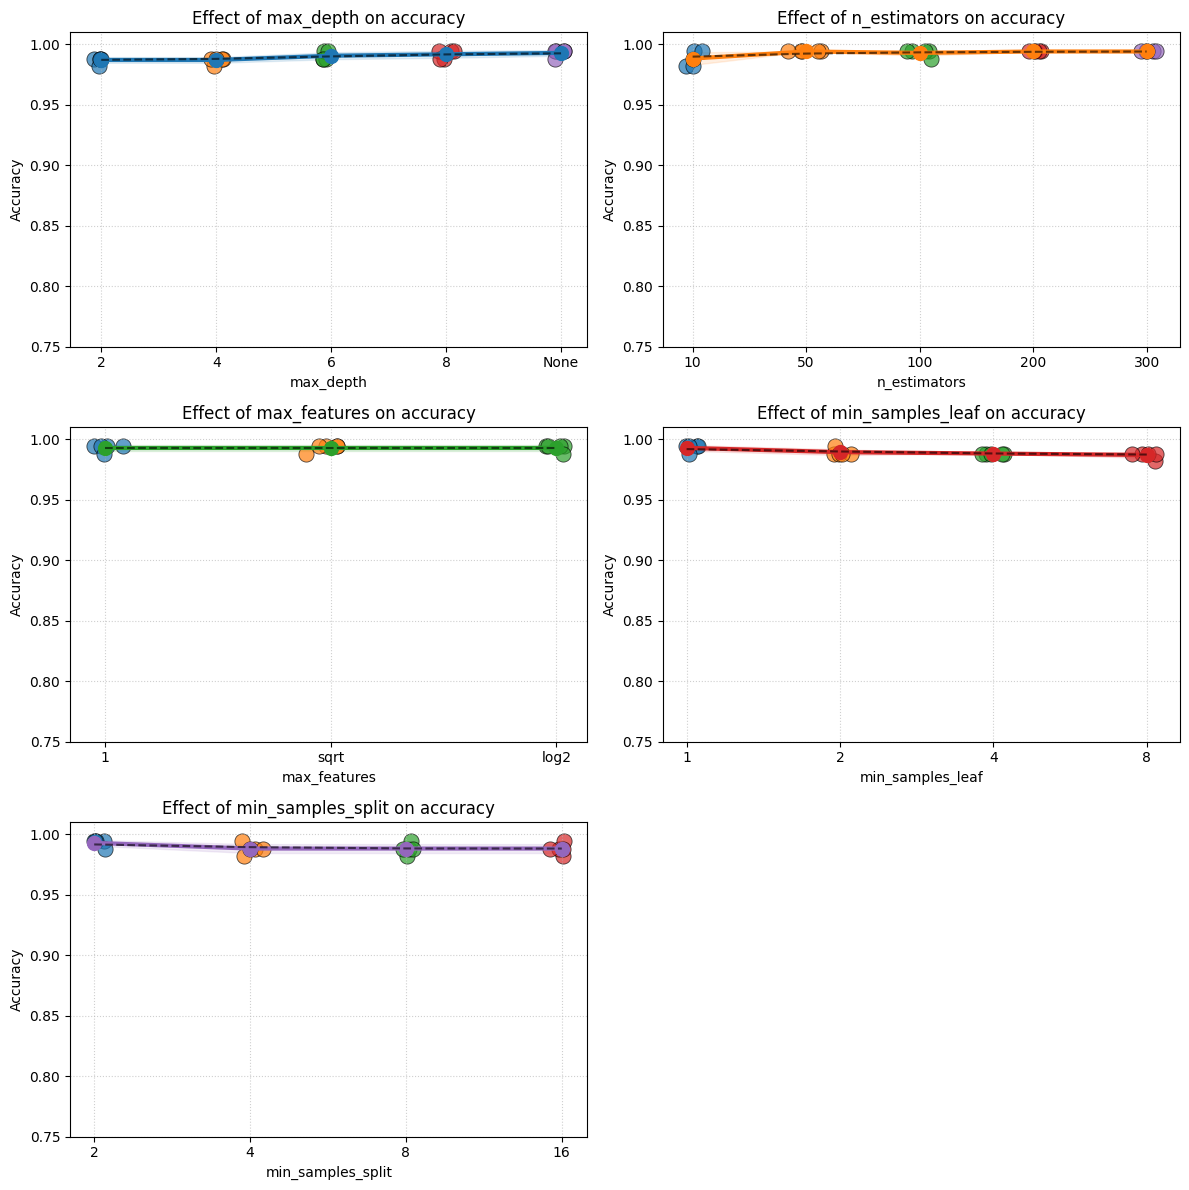

In [10]:
from sklearn.metrics import accuracy_score
import math
import random

# Store results for each hyperparameter we test
param_results = {}

# Small helper: trains a model several times with different seeds
# so we can see how stable each hyperparameter setting is.
def repeat_eval(model_builder, repeats=5):
    scores = []
    for seed in range(repeats):
        m = model_builder(seed)
        m.fit(X_train_final, y_train_final)
        scores.append(accuracy_score(y_test_final, m.predict(X_test_final)))
    return np.mean(scores), np.std(scores), scores


# 1) max_depth — check how tree depth affects accuracy
depth_values = [2, 4, 6, 8, None]
depth_means, depth_stds, depth_all = [], [], []
for d in depth_values:
    mean, std, scores = repeat_eval(
        lambda s: RandomForestClassifier(n_estimators=100, max_depth=d, random_state=42+s)
    )
    depth_means.append(mean)
    depth_stds.append(std)
    depth_all.append(scores)
param_results['max_depth'] = (depth_values, depth_means, depth_stds, depth_all)


# 2) n_estimators — number of trees in the forest
tree_values = [10, 50, 100, 200, 300]
tree_means, tree_stds, tree_all = [], [], []
for n in tree_values:
    mean, std, scores = repeat_eval(
        lambda s: RandomForestClassifier(n_estimators=n, max_depth=None, random_state=42+s)
    )
    tree_means.append(mean)
    tree_stds.append(std)
    tree_all.append(scores)
param_results['n_estimators'] = (tree_values, tree_means, tree_stds, tree_all)


# 3) max_features — how many features each split is allowed to use
feat_values = [1, 'sqrt', 'log2']
feat_means, feat_stds, feat_all = [], [], []
for f in feat_values:
    mean, std, scores = repeat_eval(
        lambda s: RandomForestClassifier(max_features=f, random_state=42+s)
    )
    feat_means.append(mean)
    feat_stds.append(std)
    feat_all.append(scores)
param_results['max_features'] = (feat_values, feat_means, feat_stds, feat_all)


# 4) min_samples_leaf — minimum samples allowed in a leaf node
leaf_values = [1, 2, 4, 8]
leaf_means, leaf_stds, leaf_all = [], [], []
for l in leaf_values:
    mean, std, scores = repeat_eval(
        lambda s: RandomForestClassifier(min_samples_leaf=l, n_estimators=100, random_state=42+s)
    )
    leaf_means.append(mean)
    leaf_stds.append(std)
    leaf_all.append(scores)
param_results['min_samples_leaf'] = (leaf_values, leaf_means, leaf_stds, leaf_all)


# 5) min_samples_split — minimum samples needed to split a node
split_values = [2, 4, 8, 16]
split_means, split_stds, split_all = [], [], []
for ms in split_values:
    mean, std, scores = repeat_eval(
        lambda s: RandomForestClassifier(min_samples_split=ms, n_estimators=100, random_state=42+s)
    )
    split_means.append(mean)
    split_stds.append(std)
    split_all.append(scores)
param_results['min_samples_split'] = (split_values, split_means, split_stds, split_all)


# Plotting each hyperparameter’s effect in a bold, clear style
params = list(param_results.keys())
n = len(params)
cols = 2
rows = math.ceil(n / cols)
plt.figure(figsize=(12, rows * 4))

cmap = plt.get_cmap('tab10')

for i, name in enumerate(params):
    vals, means, stds, alls = param_results[name]
    ax = plt.subplot(rows, cols, i + 1)

    # x-axis positions
    x = np.arange(len(vals))

    # Shade region = mean ± std (shows stability)
    ax.fill_between(
        x, np.array(means) - np.array(stds), np.array(means) + np.array(stds),
        color=cmap(i), alpha=0.12
    )

    # Mean accuracy line
    ax.plot(x, means, marker='o', linewidth=3, markersize=10, color=cmap(i))

    # Plot individual trial points with slight jitter so they don’t overlap
    for xi, scorelist in enumerate(alls):
        ys = np.array(scorelist)
        xs = np.full_like(ys, xi) + (np.random.randn(len(ys)) * 0.06)
        ax.scatter(xs, ys, s=120, alpha=0.7, edgecolor='k', linewidth=0.6)

    # Optional smoothing line (just to show a smoother trend)
    try:
        from scipy.ndimage import gaussian_filter1d
        smooth = gaussian_filter1d(np.array(means), sigma=0.8)
        ax.plot(x, smooth, linestyle='--', color='k', alpha=0.6)
    except:
        pass

    # Labels and look
    ax.set_xticks(x)
    ax.set_xticklabels([str(v) for v in vals])
    ax.set_xlabel(name)
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0.75, 1.01)
    ax.set_title(f'Effect of {name} on accuracy')
    ax.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()


## 9. Hyperparameter tuning: GridSearchCV

We run GridSearchCV on a sensible grid and inspect the best parameters and CV scores.


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best CV score: 0.9849683544303798
Best params: {'max_depth': 6, 'max_features': 1, 'min_samples_leaf': 1, 'n_estimators': 50}


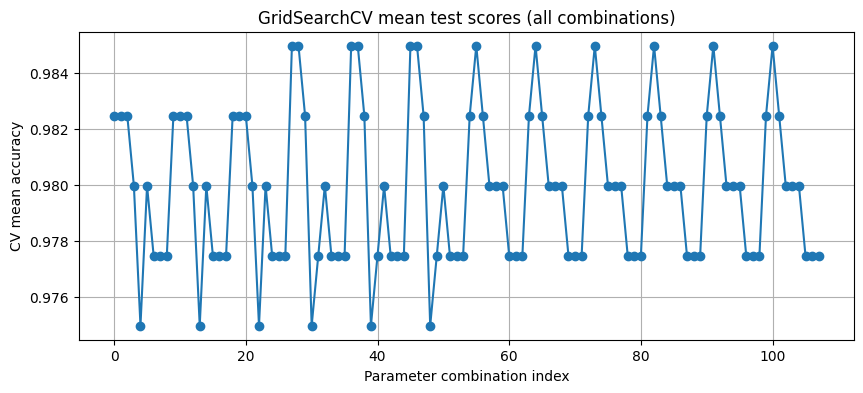

In [11]:
# Define the grid of hyperparameters we want to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 8, None],
    'max_features': [1, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4]
}

# Run GridSearchCV to test every combination using 5-fold cross validation
grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search on the chosen feature set
grid.fit(X_train_final, y_train_final)

# Print the best settings and their cross-validated accuracy
print('Best CV score:', grid.best_score_)
print('Best params:', grid.best_params_)

# Extract results and plot the mean CV scores across combinations
results = grid.cv_results_
means = results['mean_test_score']
stds = results['std_test_score']

plt.figure(figsize=(10,4))
plt.plot(means, marker='o')
plt.title('GridSearchCV mean test scores (all combinations)')
plt.xlabel('Parameter combination index')
plt.ylabel('CV mean accuracy')
plt.grid(True)
plt.show()


## 10. Evaluate best model and final interpretation

We show the confusion matrix, classification report, and final decision boundary (if 2D).


Final test accuracy: 0.9883040935672515

Classification report:

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        64
           1       0.98      1.00      0.99       107

    accuracy                           0.99       171
   macro avg       0.99      0.98      0.99       171
weighted avg       0.99      0.99      0.99       171



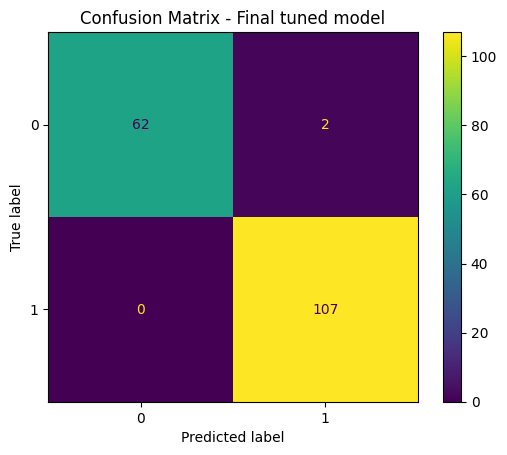

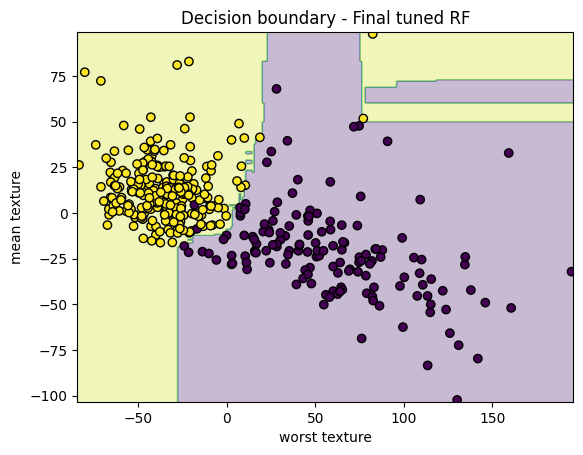

In [12]:
# Use the best model found by GridSearchCV
best = grid.best_estimator_

# Make predictions on the final test set
y_pred_final = best.predict(X_test_final)

# Print accuracy and a detailed classification report
print('Final test accuracy:', accuracy_score(y_test_final, y_pred_final))
print('\nClassification report:\n')
print(classification_report(y_test_final, y_pred_final))

# Confusion matrix for a clearer view of correct/incorrect predictions
cm = confusion_matrix(y_test_final, y_pred_final)
ConfusionMatrixDisplay(cm).plot()
plt.title('Confusion Matrix - Final tuned model')
plt.show()

# If the final feature space is 2D, show the decision boundary
if X_train_final.shape[1] == 2:
    plot_decision_boundary(best, X_train_final, y_train_final,
                           title='Decision boundary - Final tuned RF')


Github Link : https://github.com/Anirudh2302/breast-cancer-wisconsin-rf-analysis